# Project

### Imports

Content:

- Context / intro -> table of content, distortion, nb of sources, impairments, test parameters
- Subjective QA -> MOS/CI, significance (ANOVA, post-hoc), SI/TI
- Objective QA -> Choosing metrics (e.g. not ssim, LP/PS, VIF, VMAF, ...)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import seaborn as sns
import pandas as pd
import cv2 as cv
import lpips
import torch
import re

from config import DATA_PATH, VIDEOS_PATH, SAVE_PATH # local paths

### Pretreatment of the data

In [2]:
file_path = DATA_PATH + "IRCCyN_IVC_DIBR_Videos_Scores.xls"

df_base= pd.read_excel(file_path, skiprows=[0])
nb = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
df_cleaned = df_base.drop(columns=nb)
df_videos = df_cleaned.drop(columns=['Unnamed: 33', 'std'])
df_videos = df_videos.rename(columns={'Unnamed: 0': 'Video'})
df_videos.head()

,Video,MOS,CI
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474


In [3]:
# Adding video path by matching the MOS columns
df_base_DMOS = pd.read_excel(file_path, sheet_name='DMOS', skiprows=[0])
df_cleaned_DMOS = df_base_DMOS[['Unnamed: 0', 'MOS']]
df_cleaned_DMOS = df_cleaned_DMOS.rename(columns={'Unnamed: 0': 'Video_path'})

if (df_cleaned_DMOS['MOS'].values == df_videos['MOS'].values).all():
    # Add .avi extension if not already present
    df_videos['Video_path'] = df_cleaned_DMOS['Video_path'].apply(
        lambda x: x if x.endswith('.avi') else x + '.avi'
    )
    df_videos[['Video', 'Video_path', 'MOS']].head()
else:
    print("Les colonnes MOS ne correspondent pas!")


In [4]:
df_videos["Algo"] = pd.Series(dtype='object')
df_videos["Video_ID"] = pd.Series(dtype='object')
df_videos["ref_video_path"] = pd.Series(dtype='object')

# 1 : Video_ID x Algo
for index, row in df_videos.iterrows():
    video_name = row["Video"]

    # Source
    if "Book_arrival" in video_name or "book_arrival" in video_name:
        df_videos.at[index, "Video_ID"] = "Book_arrival"
    elif "Lovebird1" in video_name or "lovebird1" in video_name or 'lovebird' in video_name:
        df_videos.at[index, "Video_ID"] = "Lovebird1"
    elif "Newspaper" in video_name or "newspaper" in video_name:
        df_videos.at[index, "Video_ID"] = "Newspaper"

    # Algo
    if "Fehn_c" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_c"
    elif "Fehn_i" in video_name:
        df_videos.at[index, "Algo"] = "Fehn_i"
    elif "Holes" in video_name:
        df_videos.at[index, "Algo"] = "Holes"
    elif "ICIP_TMM" in video_name:
        df_videos.at[index, "Algo"] = "ICIP_TMM"
    elif "ICME" in video_name:
        df_videos.at[index, "Algo"] = "ICME"
    elif "MPEG" in video_name:
        df_videos.at[index, "Algo"] = "MPEG"
    elif "Muller" in video_name:
        df_videos.at[index, "Algo"] = "Muller"
    else : 
        df_videos.at[index, "Algo"] = "Original"

# Original video list: {(Video_ID, cam_number): video_path}
original_videos_dict = {}

for index, row in df_videos.iterrows():
    if row["Algo"] == "Original":
        video_path = row["Video_path"]
        video_id = row["Video_ID"]

        # "Book_arrival_8.avi" -> 8
        match = re.search(r'_(\d+)\.avi$', video_path)
        if match:
            cam_number = int(match.group(1))
            key = (video_id, cam_number)
            original_videos_dict[key] = video_path

print(f"{len(original_videos_dict)} original videos found")
#print(f"{list(original_videos_dict.items())[:3]}")

# 2 : Find the original video that the distorded videos tries to predicts
not_count = 0

for index, row in df_videos.iterrows():
    if row["Algo"] != "Original":
        video_name = row["Video"]
        video_id = row["Video_ID"]
        
        # "6_to_8" -> cam_to=8
        match = re.search(r'(\d+)_to_(\d+)', video_name)
        if match:
            cam_to = int(match.group(2))
            key = (video_id, cam_to)
            if key in original_videos_dict:
                df_videos.at[index, "ref_video_path"] = original_videos_dict[key]
            else:
                df_videos.at[index, "ref_video_path"] = None
                not_found += 1
        else:
            df_videos.at[index, "ref_video_path"] = None
            not_found += 1
    else:
        # No ref if it's an original video
        df_videos.at[index, "ref_video_path"] = None

print(f"{not_count} videos not found")
print(f"Videos found : {len(df_videos)}")
print(f"Original videos : {(df_videos['Algo'] == 'Original').sum()}")
print(f"Videos with reference : {df_videos['ref_video_path'].notna().sum()}")

9 original videos found
0 videos not found
Videos found : 102
Original videos : 18
Videos with reference : 84


In [5]:
# Save the dataframe to CSV for future use
output_path = SAVE_PATH + "df_videos_processed.csv"
df_videos.to_csv(output_path, index=False)
print(f"Data saved to: {output_path}")
print(f"Rows saved: {len(df_videos)}")
print(f"Columns saved: {list(df_videos.columns)}")

Data saved to: results/df_videos_processed.csv
Rows saved: 102
Columns saved: ['Video', 'MOS', 'CI', 'Video_path', 'Algo', 'Video_ID', 'ref_video_path']


In [6]:
df_videos.head()

,Video,MOS,CI,Video_path,Algo,Video_ID,ref_video_path
0,Fehn_c_Book_arrival_bh_8_to_10,2.21875,0.270256,Book_arrival_A1_8_to_10.avi,Fehn_c,Book_arrival,Book_arrival_cam_10.avi
1,Fehn_c_Book_arrival_bh_10_to_8,2.15625,0.301427,Book_arrival_A1_10_to_8.avi,Fehn_c,Book_arrival,Book_arrival_cam_08.avi
2,Fehn_c_Book_arrival_sh_8_to_9,3.40625,0.298299,Book_arrival_A1_8_to_9.avi,Fehn_c,Book_arrival,Book_arrival_cam_09.avi
3,Fehn_c_Book_arrival_sh_10_to_9,3.56250,0.258958,Book_arrival_A1_10_to_9.avi,Fehn_c,Book_arrival,Book_arrival_cam_09.avi
4,Fehn_i_Book_arrival_bh_8_to_10,2.03125,0.280474,Book_arrival_A2_8_to_10.avi,Fehn_i,Book_arrival,Book_arrival_cam_10.avi


In [ ]:
# print the line where Newspaper_A5_4_to_5.avi is located
newspaper_line = df_videos[df_videos['Video_path'] == 'Newspaper_A5_4_to_5.avi']
print(newspaper_line)
# print the algos of the video_path called Newpaper_A{index}_* for index in range(1,6):
for i in range(1, 6):
    pattern = f"Newspaper_A{i}_"
    algos = df_videos[df_videos['Video_path'].str.startswith(pattern)]['Algo'].unique()
    print(f"Algos for videos starting with {pattern}: {algos}")
#df_videos["Algo"].unique()

### Statistical analysis of MOS and CI

#### MOS and CI visualization

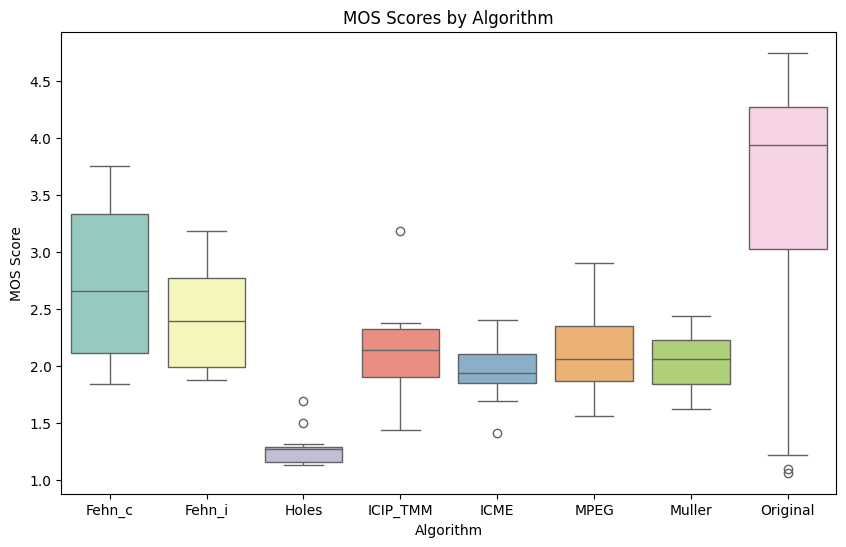

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Algo", y="MOS", data=df_videos, hue="Algo", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

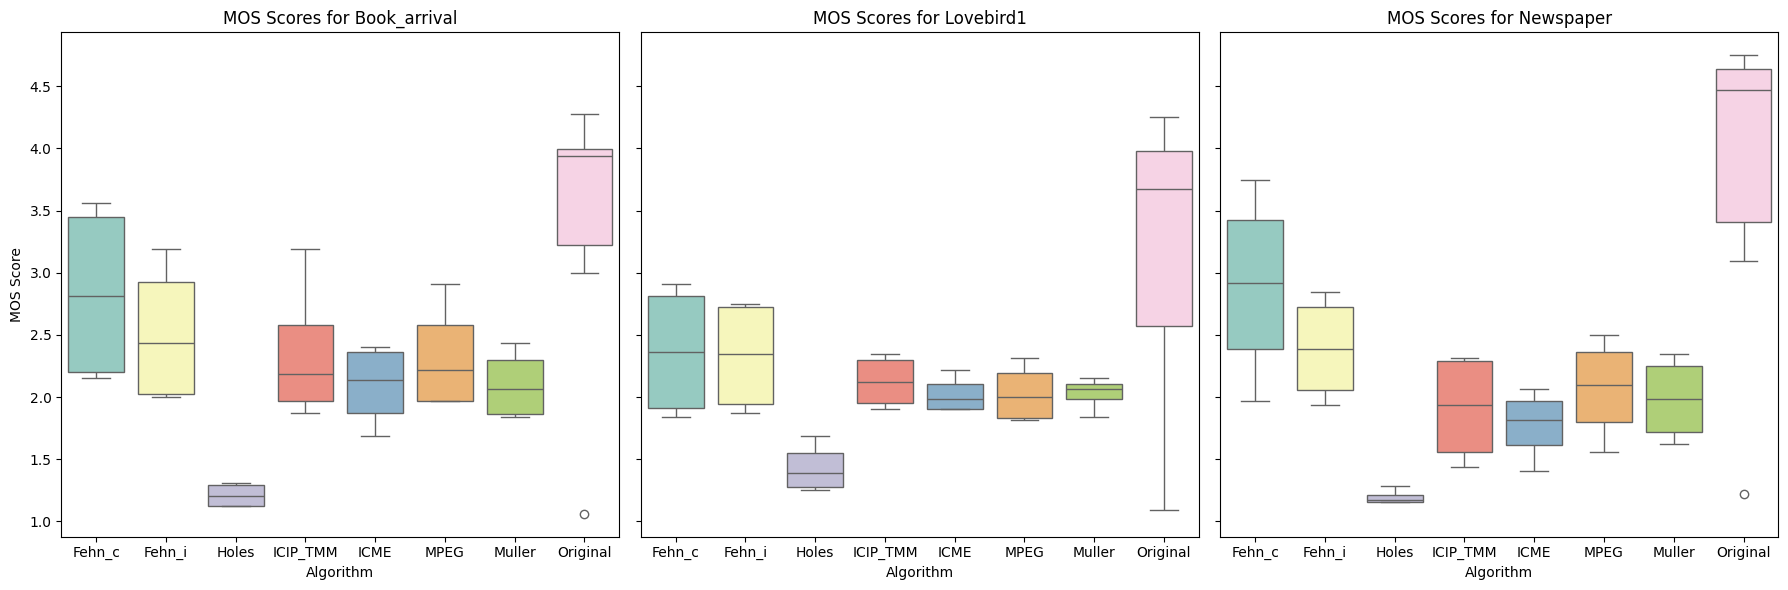

In [8]:
video_ids = df_videos["Video_ID"].unique()
fig, axes = plt.subplots(1, len(video_ids), figsize=(18,6), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i]
    subset = df_videos[df_videos["Video_ID"] == video_id]
    sns.boxplot(x="Algo", y="MOS", data=subset, hue="Algo", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [9]:
# Display MOS and CI from dataframe
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	2.698 ± 0.282  [2.415, 2.980]
Fehn_i         	2.411 ± 0.263  [2.149, 2.674]
Holes          	1.279 ± 0.159  [1.120, 1.438]
ICIP_TMM       	2.130 ± 0.215  [1.915, 2.346]
ICME           	1.964 ± 0.223  [1.741, 2.186]
MPEG           	2.141 ± 0.225  [1.916, 2.366]
Muller         	2.039 ± 0.222  [1.817, 2.261]
Original       	3.436 ± 0.246  [3.190, 3.681]


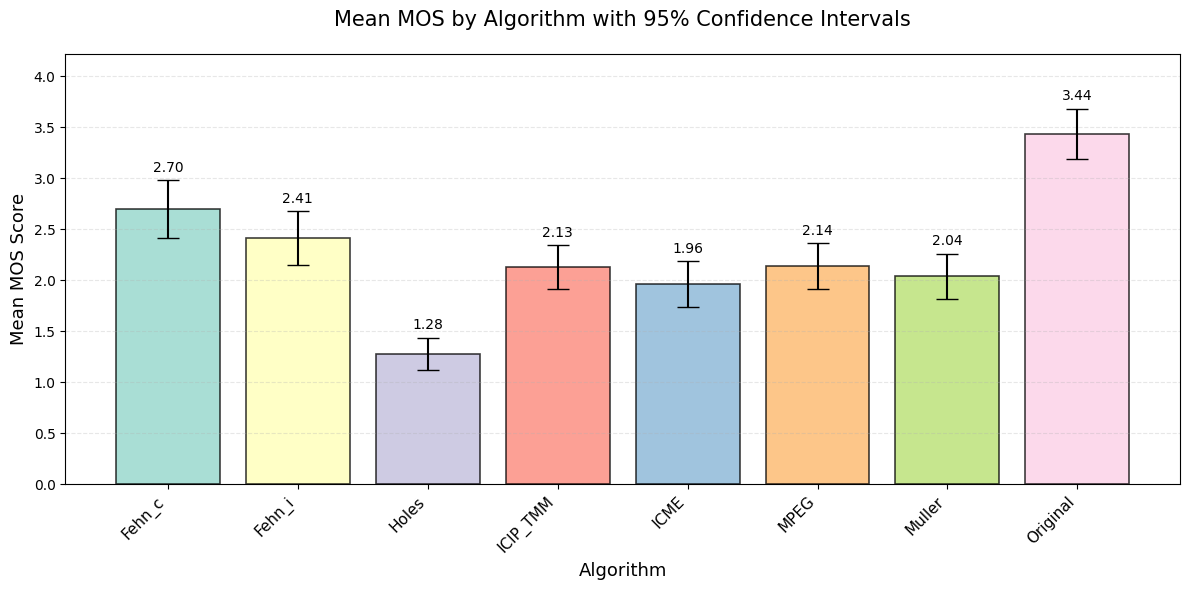

Non-overlapping CIs suggest statistically significant differences


In [10]:
# Visualization of Mean MOS with CI from dataframe
fig, ax = plt.subplots(figsize=(12, 6))

# Get means and CIs from dataframe
algos = sorted(df_videos['Algo'].unique())
means = []
cis = []

for algo in algos:
    subset = df_videos[df_videos['Algo'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI'].mean())

# Create bar plot with error bars
x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

#### Anova

In [11]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df_videos.groupby('Algo')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 13.9396
P-value: 2.847592989122031e-12

Conclusion: There are statistically significant differences between algorithms (p < 0.05)


In [12]:
#test de Dunnett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dunnett = pairwise_tukeyhsd(endog=df_videos['MOS'], groups=df_videos['Algo'], alpha=0.05)
print(dunnett)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  Fehn_c   Fehn_i  -0.2865 0.9576  -1.102  0.5291  False
  Fehn_c    Holes  -1.4193    0.0 -2.2348 -0.6037   True
  Fehn_c ICIP_TMM  -0.5677 0.3864 -1.3833  0.2478  False
  Fehn_c     ICME  -0.7344 0.1095 -1.5499  0.0812  False
  Fehn_c     MPEG  -0.5573 0.4109 -1.3728  0.2583  False
  Fehn_c   Muller  -0.6589 0.2064 -1.4744  0.1567  False
  Fehn_c Original   0.7378 0.0539 -0.0066  1.4823  False
  Fehn_i    Holes  -1.1328  0.001 -1.9484 -0.3173   True
  Fehn_i ICIP_TMM  -0.2812 0.9616 -1.0968  0.5343  False
  Fehn_i     ICME  -0.4479 0.6855 -1.2635  0.3676  False
  Fehn_i     MPEG  -0.2708 0.9687 -1.0864  0.5447  False
  Fehn_i   Muller  -0.3724 0.8478 -1.1879  0.4432  False
  Fehn_i Original   1.0243 0.0012  0.2798  1.7688   True
   Holes ICIP_TMM   0.8516 0.0342   0.036  1.6671   True
   Holes     ICME   0.6849 0.16

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df_videos['MOS'], df_videos['Algo'])

result = mc.tukeyhsd()

filtered_results = result.summary().data[1:] 
filtered_results = [row for row in filtered_results if 'Original' in row[0] or 'Original' in row[1]]
for rows in filtered_results:
    print(rows)

['Fehn_c', 'Original', np.float64(0.7378), np.float64(0.0539), np.float64(-0.0066), np.float64(1.4823), np.False_]
['Fehn_i', 'Original', np.float64(1.0243), np.float64(0.0012), np.float64(0.2798), np.float64(1.7688), np.True_]
['Holes', 'Original', np.float64(2.1571), np.float64(0.0), np.float64(1.4126), np.float64(2.9016), np.True_]
['ICIP_TMM', 'Original', np.float64(1.3056), np.float64(0.0), np.float64(0.5611), np.float64(2.05), np.True_]
['ICME', 'Original', np.float64(1.4722), np.float64(0.0), np.float64(0.7277), np.float64(2.2167), np.True_]
['MPEG', 'Original', np.float64(1.2951), np.float64(0.0), np.float64(0.5506), np.float64(2.0396), np.True_]
['Muller', 'Original', np.float64(1.3967), np.float64(0.0), np.float64(0.6522), np.float64(2.1412), np.True_]


In [14]:
print("=" * 70)
print("SUMMARY: Comparison of Each Algorithm vs. Original (Control)")
print("=" * 70)
print(f"{'Algorithm':<15} {'Mean Diff':<17} {'95% CI':<12} {'p-value':<6} {'Significant?'}")
print("-" * 70)

for row in filtered_results:
    group1, group2, meandiff, pval, lower, upper, reject = row
    if 'Original' in [group1, group2]:
        other_group = group1 if group2 == 'Original' else group2
        meandiff_adj = meandiff if group1 == 'Original' else -meandiff
        lower_adj = lower if group1 == 'Original' else -lower
        upper_adj = upper if group1 == 'Original' else -upper
        
        ci_str = f"[{lower_adj:6.3f}, {upper_adj:6.3f}]"
        sig_str = "YES" if reject else "NO"
        
        print(f"{other_group:<15} {meandiff_adj:>10.4f}  {ci_str:<20} {pval:>6}  {sig_str}")

print("=" * 70)
print("\nInterpretation:")
print("- Positive Mean Diff: Algorithm performs BETTER than Original")
print("- Negative Mean Diff: Algorithm performs WORSE than Original")
print("- Significant (p < 0.05): The difference is statistically meaningful")

SUMMARY: Comparison of Each Algorithm vs. Original (Control)
Algorithm       Mean Diff         95% CI       p-value Significant?
----------------------------------------------------------------------
Fehn_c             -0.7378  [ 0.007, -1.482]     0.0539  NO
Fehn_i             -1.0243  [-0.280, -1.769]     0.0012  YES
Holes              -2.1571  [-1.413, -2.902]        0.0  YES
ICIP_TMM           -1.3056  [-0.561, -2.050]        0.0  YES
ICME               -1.4722  [-0.728, -2.217]        0.0  YES
MPEG               -1.2951  [-0.551, -2.040]        0.0  YES
Muller             -1.3967  [-0.652, -2.141]        0.0  YES

Interpretation:
- Positive Mean Diff: Algorithm performs BETTER than Original
- Negative Mean Diff: Algorithm performs WORSE than Original
- Significant (p < 0.05): The difference is statistically meaningful


### SI/TI

#### Def

In [15]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        # Calculate SI for current frame
        si = calculate_SI(frame)
        si_values.append(si)
        
        # Calculate TI if we have a previous frame
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    # Mean, max and 95th percentile
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    p95_si = np.percentile(si_values, 95) if si_values else 0
    p95_ti = np.percentile(ti_values, 95) if ti_values else 0
    
    return mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti

#### SI/TI computation

In [16]:
# Calculate SI/TI for all videos in the dataset
df_videos['SI_mean'] = 0.0
df_videos['SI_max'] = 0.0
df_videos['TI_mean'] = 0.0
df_videos['TI_max'] = 0.0
df_videos['SI_p95'] = 0.0
df_videos['TI_p95'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df_videos.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    #print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        #print(f"Processing: {video_name[:50]}...")
        mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
        df_videos.at[index, 'SI_mean'] = mean_si
        df_videos.at[index, 'SI_max'] = max_si
        df_videos.at[index, 'TI_mean'] = mean_ti
        df_videos.at[index, 'TI_max'] = max_ti
        df_videos.at[index, 'SI_p95'] = p95_si
        df_videos.at[index, 'TI_p95'] = p95_ti

        # If we have values == 0, we can print a warning
        if mean_si == 0:
            print(f"Warning: SI is zero for video: {video_name}")
        if mean_ti == 0:
            print(f"Warning: TI is zero for video: {video_name}")
    else:
        print(f"Video not found: {video_path}")

print("\nSI/TI calculation complete")
print("\nSample results:")
print(df_videos[['Video_path', 'Algo', 'MOS', 'SI_mean', 'TI_mean']].head(10))

Calculating SI/TI for all videos...
This may take a few minutes...


SI/TI calculation complete

Sample results:
                    Video_path    Algo      MOS    SI_mean    TI_mean
0  Book_arrival_A1_8_to_10.avi  Fehn_c  2.21875  52.392838  11.507031
1  Book_arrival_A1_10_to_8.avi  Fehn_c  2.15625  51.247106  11.464844
2   Book_arrival_A1_8_to_9.avi  Fehn_c  3.40625  52.869261  11.376856
3  Book_arrival_A1_10_to_9.avi  Fehn_c  3.56250  51.597449  11.218186
4  Book_arrival_A2_8_to_10.avi  Fehn_i  2.03125  53.056129  11.310041
5  Book_arrival_A2_10_to_8.avi  Fehn_i  2.00000  51.697352  11.546632
6   Book_arrival_A2_8_to_9.avi  Fehn_i  3.18750  53.521942  11.310853
7  Book_arrival_A2_10_to_9.avi  Fehn_i  2.84375  51.990702  11.302561
8  Book_arrival_A7_8_to_10.avi   Holes  1.12500  69.188729  15.025163
9  Book_arrival_A7_10_to_8.avi   Holes  1.12500  75.302973  15.153406


In [17]:
df_videos.to_csv(output_path, index=False)
print(f"Data saved to: {output_path}")
print(f"Rows saved: {len(df_videos)}")
print(f"Columns saved: {list(df_videos.columns)}")

Data saved to: results/df_videos_processed.csv
Rows saved: 102
Columns saved: ['Video', 'MOS', 'CI', 'Video_path', 'Algo', 'Video_ID', 'ref_video_path', 'SI_mean', 'SI_max', 'TI_mean', 'TI_max', 'SI_p95', 'TI_p95']


#### Plots

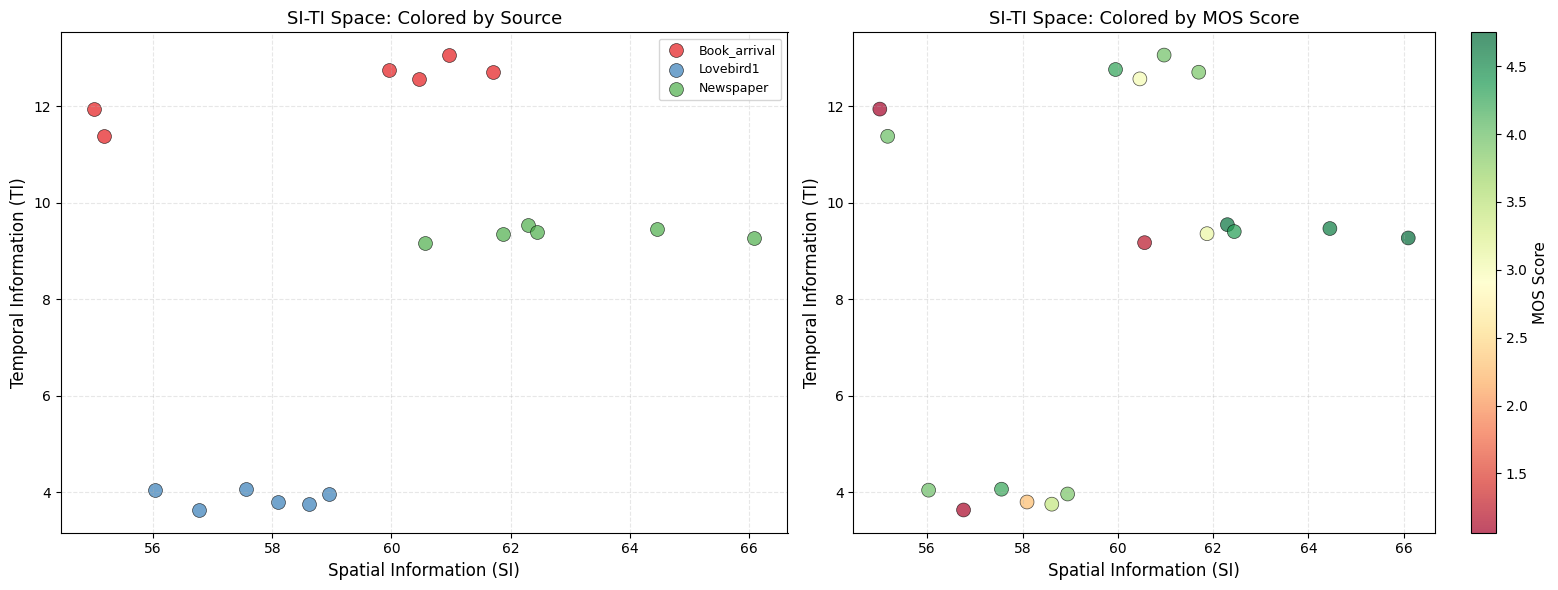

In [18]:
# CELLULE A PART : behavior of objectve metric pour discuss qhy si ti would be better for specific videos
# lancement de si ti uniquement pour les videos n'ayant pas de dégradation, les Original videos

# Calculate SI/TI for all videos in the dataset
# df_videos['SI_mean'] = 0.0
# df_videos['SI_max'] = 0.0
# df_videos['TI_mean'] = 0.0
# df_videos['TI_max'] = 0.0
# df_videos['SI_p95'] = 0.0
# df_videos['TI_p95'] = 0.0

# print("Calculating SI/TI for Original videos...")
# print("This may take a few minutes...\n")

# for index, row in df_videos[df_videos['Algo'] == 'Original'].iterrows():
#     video_name = row['Video_path']
#     video_path = os.path.join(VIDEOS_PATH, video_name)
#     #print(f"Video path: {video_path}")  
    
#     if os.path.exists(video_path):
#         #print(f"Processing: {video_name[:50]}...")
#         mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
#         df_videos.at[index, 'SI_mean'] = mean_si
#         df_videos.at[index, 'SI_max'] = max_si
#         df_videos.at[index, 'TI_mean'] = mean_ti
#         df_videos.at[index, 'TI_max'] = max_ti
#         df_videos.at[index, 'SI_p95'] = p95_si
#         df_videos.at[index, 'TI_p95'] = p95_ti

#         # If we have values == 0, we can print a warning
#         if mean_si == 0:
#             print(f"Warning: SI is zero for video: {video_name}")
#         if mean_ti == 0:
#             print(f"Warning: TI is zero for video: {video_name}")
#     else:
#         print(f"Video not found: {video_path}")

# print("\nSI/TI calculation complete")
# print("\nSample results:")
# print(df_videos[['Video_path', 'Algo', 'MOS', 'SI_mean', 'TI_mean']].head(10))


# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

subset = df_videos[df_videos['Algo'] == 'Original']

# Plot 1: SI/TI colored by Source
sources = subset['Video_ID'].unique()
colors = sns.color_palette("Set1", len(sources))
for i, source in enumerate(sources):
    source_data = subset[subset['Video_ID'] == source]
    axes[0].scatter(source_data['SI_mean'], source_data['TI_mean'], 
                    label=source, color=colors[i], alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Colored by Source', fontsize=13)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(loc='upper right', fontsize=9)

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'], 
                         c=subset['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

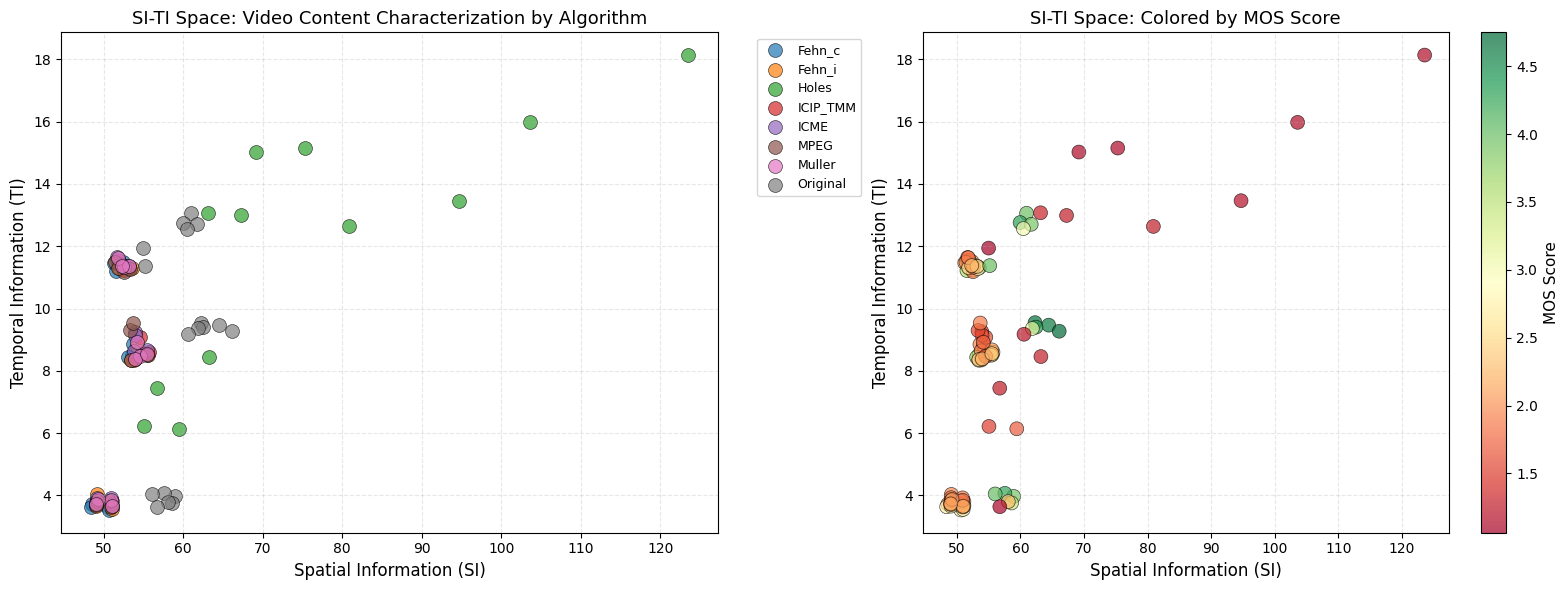


Interpretation:
- Each point represents one video
- High SI = spatially complex content (detailed scenes)
- High TI = high motion content
- Colors in right plot show if high SI/TI correlates with lower/higher MOS


In [19]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SI/TI space
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df_videos['SI_mean'], df_videos['TI_mean'], 
                         c=df_videos['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")

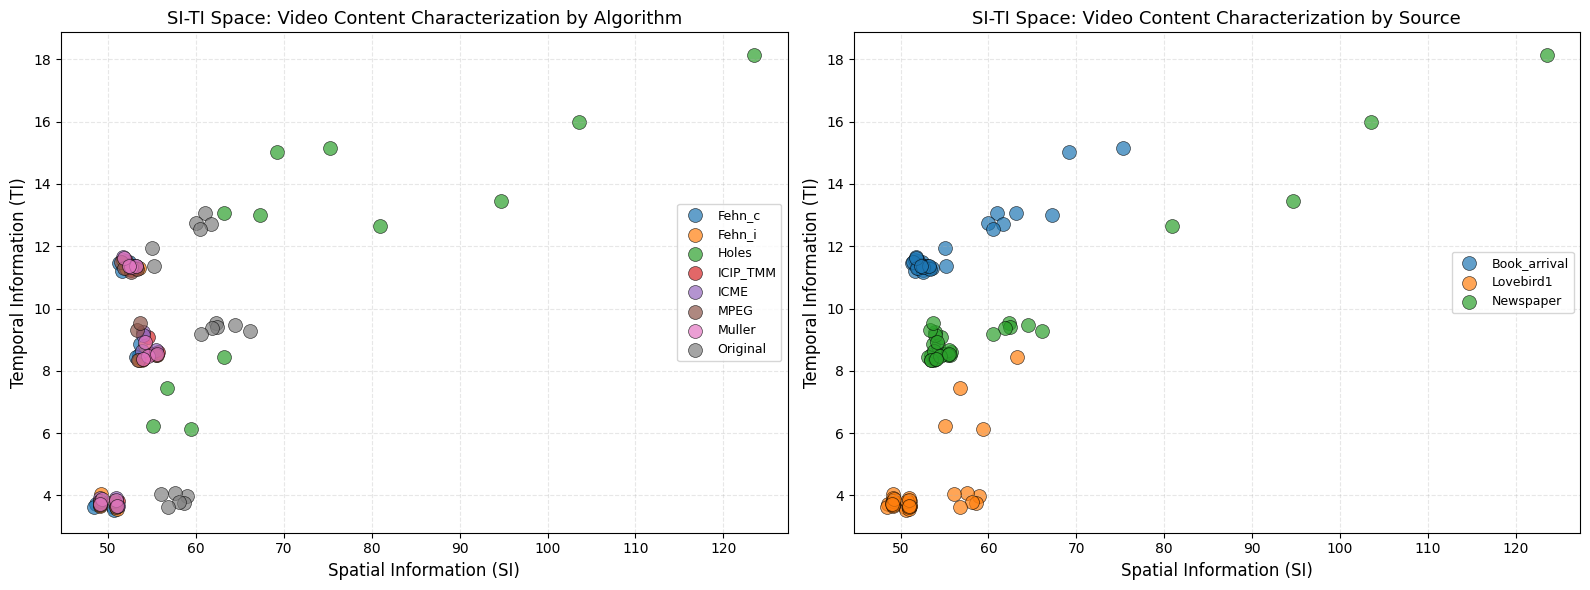

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(loc='right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

for source in sorted(df_videos['Video_ID'].unique()):
    subset = df_videos[df_videos['Video_ID'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(loc='right', fontsize=9)

plt.tight_layout()
plt.show()

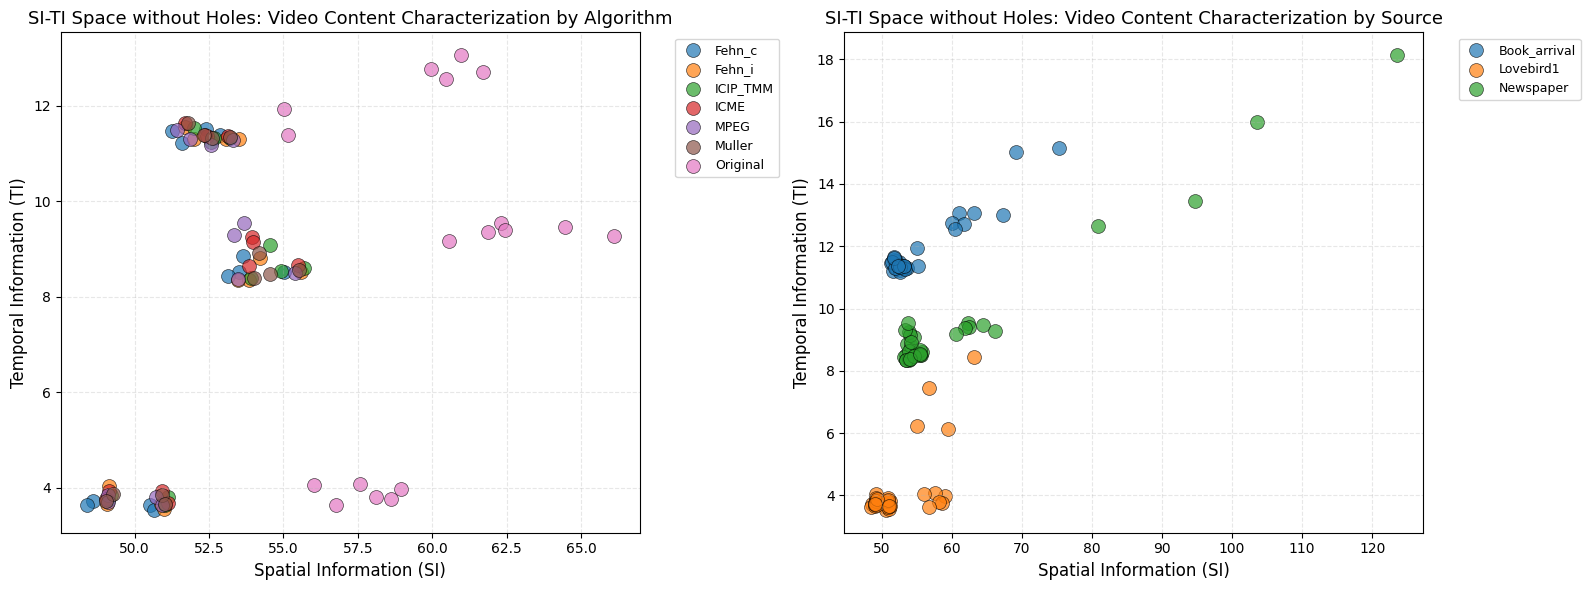

In [21]:
# Same graph but without Holes because it skews the scale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for algo in sorted(df_videos['Algo'].unique()):
    if algo == "Holes":
        continue
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space without Holes: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')
for source in sorted(df_videos['Video_ID'].unique()):
    subset = df_videos[df_videos['Video_ID'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space without Holes: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

### Objective QA : PSNR, VIF, LPIPS

##### Metrics

In [22]:
def video_psnr(path_ref, path_dis, use_y_channel=True):
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break

        if use_y_channel:
            f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2YUV)[:,:,0]
            f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2YUV)[:,:,0]

        f_ref = f_ref.astype(np.float32)
        f_dis = f_dis.astype(np.float32)

        dr = f_dis.max() - f_dis.min() if use_y_channel else 255.0
        scores.append(psnr(f_ref, f_dis, data_range=dr))

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

In [23]:
loss_fn_alex = lpips.LPIPS(net='alex') 

def video_lpips(path_ref, path_dis, device='cpu', frame_sample_rate=10):
    """
    Compute LPIPS for a video with frame sampling for optimization.
    
    Parameters:
    - path_ref: reference video path
    - path_dis: distorted video path
    - device: 'cpu' or 'cuda' (use GPU if available)
    - frame_sample_rate: sample every Nth frame (10 = process 10% of frames)
    """
    if device == 'cpu' and torch.cuda.is_available():
        device = 'cuda'
        print("Using GPU for LPIPS computation")
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []
    frame_idx = 0

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break
        
        # Sample frames: only process every Nth frame
        if frame_idx % frame_sample_rate != 0:
            frame_idx += 1
            continue
        
        frame_idx += 1

        f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2RGB)
        f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2RGB)


        f_ref_normalized = (f_ref / 127.5) - 1.0
        f_dis_normalized = (f_dis / 127.5) - 1.0

        tensor_ref = torch.tensor(f_ref_normalized, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
        tensor_dis = torch.tensor(f_dis_normalized, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

        with torch.no_grad():
            d = loss_fn_alex(tensor_ref, tensor_dis)
            scores.append(d.item())

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

def video_vif(path_ref, path_dis):
    """
    Calculate Visual Information Fidelity (VIF) for video frames using scikit-image SSIM.
    SSIM is a perceptual quality metric (range: -1 to 1, higher = better).
    Normalized to [0, 1] for consistency.
    """
    from skimage.metrics import structural_similarity as ssim
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break

        # Convert BGR to grayscale for SSIM (or use as RGB)
        f_ref_gray = cv.cvtColor(f_ref, cv.COLOR_BGR2GRAY).astype(np.float32)
        f_dis_gray = cv.cvtColor(f_dis, cv.COLOR_BGR2GRAY).astype(np.float32)

        # Compute SSIM (structural similarity, perceptual metric)
        # data_range should be the range of values (typically 255 for uint8)
        ssim_score = ssim(f_ref_gray, f_dis_gray, data_range=255)
        
        # Normalize SSIM from [-1, 1] to [0, 1]
        ssim_normalized = (ssim_score + 1) / 2
        scores.append(ssim_normalized)

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\lpips\weights\v0.1\alex.pth


##### Computation

In [24]:
df_videos['PSNR'] = np.nan
df_videos['LPIPS_alex'] = np.nan
df_videos['VIF'] = np.nan

for index, row in df_videos.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)

    if row['Algo'] == 'Original':
        df_videos.at[index, 'PSNR'] = np.nan
        df_videos.at[index, 'LPIPS_alex'] = 0.0
        df_videos.at[index, 'VIF'] = 1.0
        continue

    # Récupérer le path de la vidéo de référence (déjà trouvé dans le prétraitement)
    ref_video_name = row['ref_video_path']
    
    if pd.isna(ref_video_name):
        print(f"No ref for : {video_name}")
        continue
    
    video_ref_path = os.path.join(VIDEOS_PATH, ref_video_name)

    print(f"Video: {video_name}, ref: {ref_video_name}")

    if os.path.exists(video_path) and os.path.exists(video_ref_path):
        psnr_score = video_psnr(video_ref_path, video_path)
        lpips_score = video_lpips(video_ref_path, video_path, frame_sample_rate=15)
        vif_score = video_vif(video_ref_path, video_path)

        df_videos.at[index, 'PSNR'] = psnr_score
        df_videos.at[index, 'LPIPS_alex'] = lpips_score
        df_videos.at[index, 'VIF'] = vif_score
    else:
        if not os.path.exists(video_path):
            print(f"  Vidéo introuvable: {video_path}")

print("Objective metrics computed (PSNR + LPIPS + VIF).")
df_videos[['Video', 'Algo', 'MOS', 'ref_video_path', 'PSNR', 'LPIPS_alex', 'VIF']].head(10)

Video: Book_arrival_A1_8_to_10.avi, ref: Book_arrival_cam_10.avi
Video: Book_arrival_A1_10_to_8.avi, ref: Book_arrival_cam_08.avi
Video: Book_arrival_A1_8_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A1_10_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A2_8_to_10.avi, ref: Book_arrival_cam_10.avi
Video: Book_arrival_A2_10_to_8.avi, ref: Book_arrival_cam_08.avi
Video: Book_arrival_A2_8_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A2_10_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A7_8_to_10.avi, ref: Book_arrival_cam_10.avi
Video: Book_arrival_A7_10_to_8.avi, ref: Book_arrival_cam_08.avi
Video: Book_arrival_A7_8_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A7_10_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A6_8_to_10.avi, ref: Book_arrival_cam_10.avi
Video: Book_arrival_A6_10_to_8.avi, ref: Book_arrival_cam_08.avi
Video: Book_arrival_A6_8_to_9.avi, ref: Book_arrival_cam_09.avi
Video: Book_arrival_A6_10_to_

,Video,Algo,MOS,ref_video_path,PSNR,LPIPS_alex,VIF
0,Fehn_c_Book_arrival_bh_8_to_10,Fehn_c,2.21875,Book_arrival_cam_10.avi,17.256302,0.377928,0.787065
1,Fehn_c_Book_arrival_bh_10_to_8,Fehn_c,2.15625,Book_arrival_cam_08.avi,17.043963,0.366270,0.790014
2,Fehn_c_Book_arrival_sh_8_to_9,Fehn_c,3.40625,Book_arrival_cam_09.avi,20.438228,0.236507,0.825442
3,Fehn_c_Book_arrival_sh_10_to_9,Fehn_c,3.56250,Book_arrival_cam_09.avi,20.225193,0.241588,0.827187
4,Fehn_i_Book_arrival_bh_8_to_10,Fehn_i,2.03125,Book_arrival_cam_10.avi,23.707061,0.123648,0.910834
5,Fehn_i_Book_arrival_bh_10_to_8,Fehn_i,2.00000,Book_arrival_cam_08.avi,23.518376,0.120264,0.911908
6,Fehn_i_Book_arrival_sh_8_to_9,Fehn_i,3.18750,Book_arrival_cam_09.avi,30.633138,0.085750,0.945898
7,Fehn_i_Book_arrival_sh_10_to_9,Fehn_i,2.84375,Book_arrival_cam_09.avi,30.749369,0.085551,0.946228
8,Holes_Book_arrival_bh_8_to_10,Holes,1.12500,Book_arrival_cam_10.avi,20.911934,0.215252,0.896691
9,Holes_Book_arrival_bh_10_to_8,Holes,1.12500,Book_arrival_cam_08.avi,17.864934,0.246733,0.895108


In [25]:
df_videos.to_csv(output_path, index=False)
print(f"Data saved to: {output_path}")
print(f"Rows saved: {len(df_videos)}")
print(f"Columns saved: {list(df_videos.columns)}")

Data saved to: results/df_videos_processed.csv
Rows saved: 102
Columns saved: ['Video', 'MOS', 'CI', 'Video_path', 'Algo', 'Video_ID', 'ref_video_path', 'SI_mean', 'SI_max', 'TI_mean', 'TI_max', 'SI_p95', 'TI_p95', 'PSNR', 'LPIPS_alex', 'VIF']


#### Plots

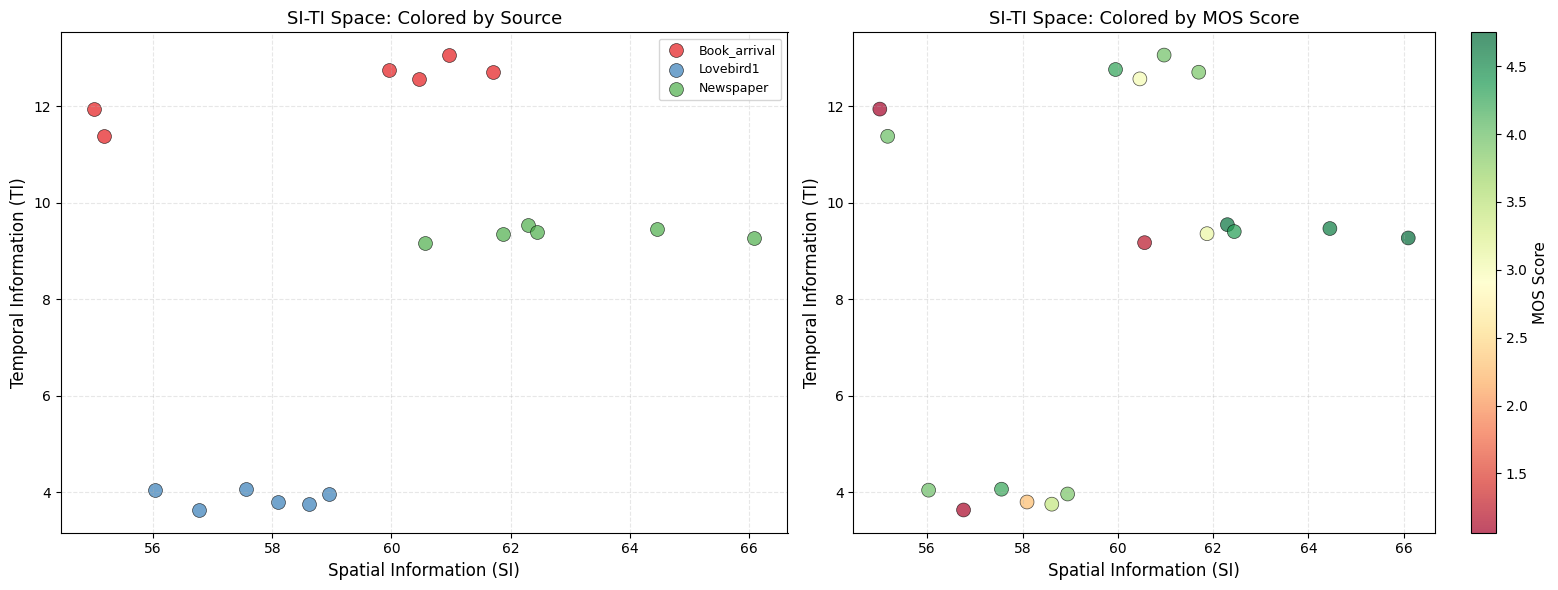

In [26]:
# CELLULE A PART : behavior of objectve metric pour discuss qhy si ti would be better for specific videos
# lancement de si ti uniquement pour les videos n'ayant pas de dégradation, les Original videos

# Calculate SI/TI for all videos in the dataset
# df_videos['SI_mean'] = 0.0
# df_videos['SI_max'] = 0.0
# df_videos['TI_mean'] = 0.0
# df_videos['TI_max'] = 0.0
# df_videos['SI_p95'] = 0.0
# df_videos['TI_p95'] = 0.0

# print("Calculating SI/TI for Original videos...")
# print("This may take a few minutes...\n")

# for index, row in df_videos[df_videos['Algo'] == 'Original'].iterrows():
#     video_name = row['Video_path']
#     video_path = os.path.join(VIDEOS_PATH, video_name)
#     #print(f"Video path: {video_path}")  
    
#     if os.path.exists(video_path):
#         #print(f"Processing: {video_name[:50]}...")
#         mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
#         df_videos.at[index, 'SI_mean'] = mean_si
#         df_videos.at[index, 'SI_max'] = max_si
#         df_videos.at[index, 'TI_mean'] = mean_ti
#         df_videos.at[index, 'TI_max'] = max_ti
#         df_videos.at[index, 'SI_p95'] = p95_si
#         df_videos.at[index, 'TI_p95'] = p95_ti

#         # If we have values == 0, we can print a warning
#         if mean_si == 0:
#             print(f"Warning: SI is zero for video: {video_name}")
#         if mean_ti == 0:
#             print(f"Warning: TI is zero for video: {video_name}")
#     else:
#         print(f"Video not found: {video_path}")

# print("\nSI/TI calculation complete")
# print("\nSample results:")
# print(df_videos[['Video_path', 'Algo', 'MOS', 'SI_mean', 'TI_mean']].head(10))


# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

subset = df_videos[df_videos['Algo'] == 'Original']

# Plot 1: SI/TI colored by Source
sources = subset['Video_ID'].unique()
colors = sns.color_palette("Set1", len(sources))
for i, source in enumerate(sources):
    source_data = subset[subset['Video_ID'] == source]
    axes[0].scatter(source_data['SI_mean'], source_data['TI_mean'], 
                    label=source, color=colors[i], alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Colored by Source', fontsize=13)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(loc='upper right', fontsize=9)

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'], 
                         c=subset['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

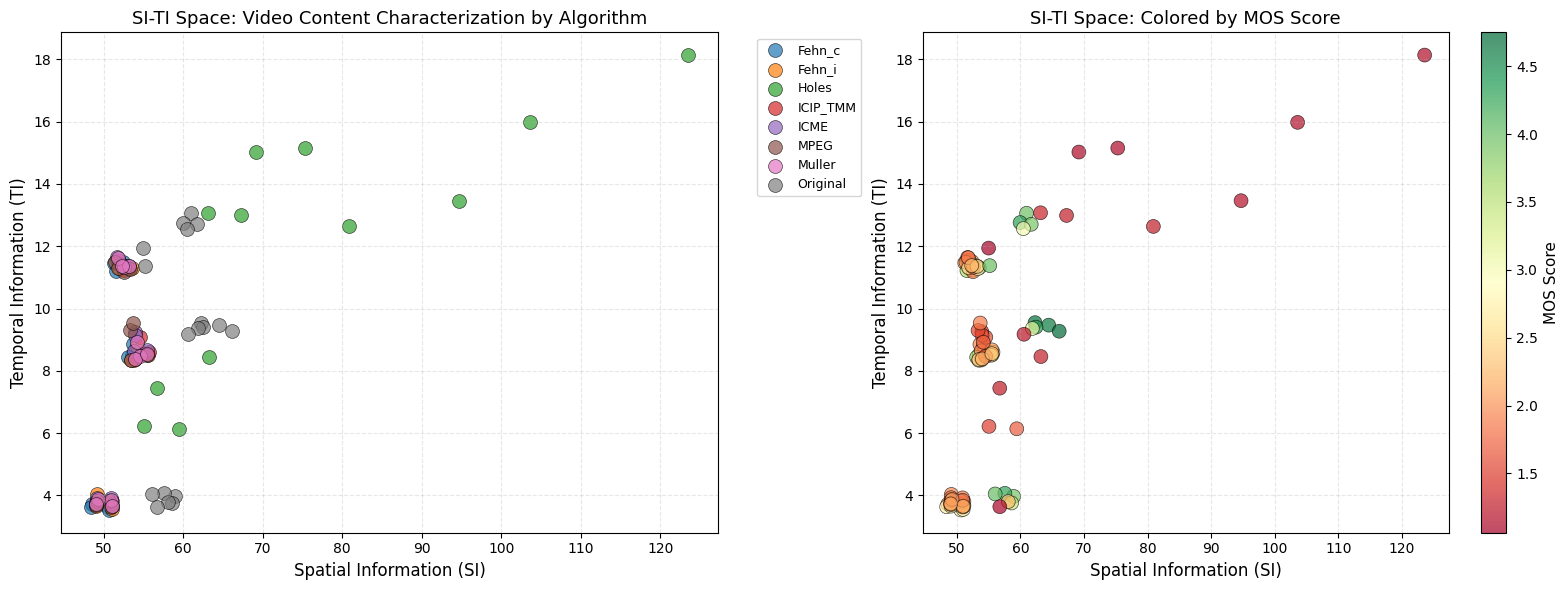


Interpretation:
- Each point represents one video
- High SI = spatially complex content (detailed scenes)
- High TI = high motion content
- Colors in right plot show if high SI/TI correlates with lower/higher MOS


In [27]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SI/TI space
for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df_videos['SI_mean'], df_videos['TI_mean'], 
                         c=df_videos['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")

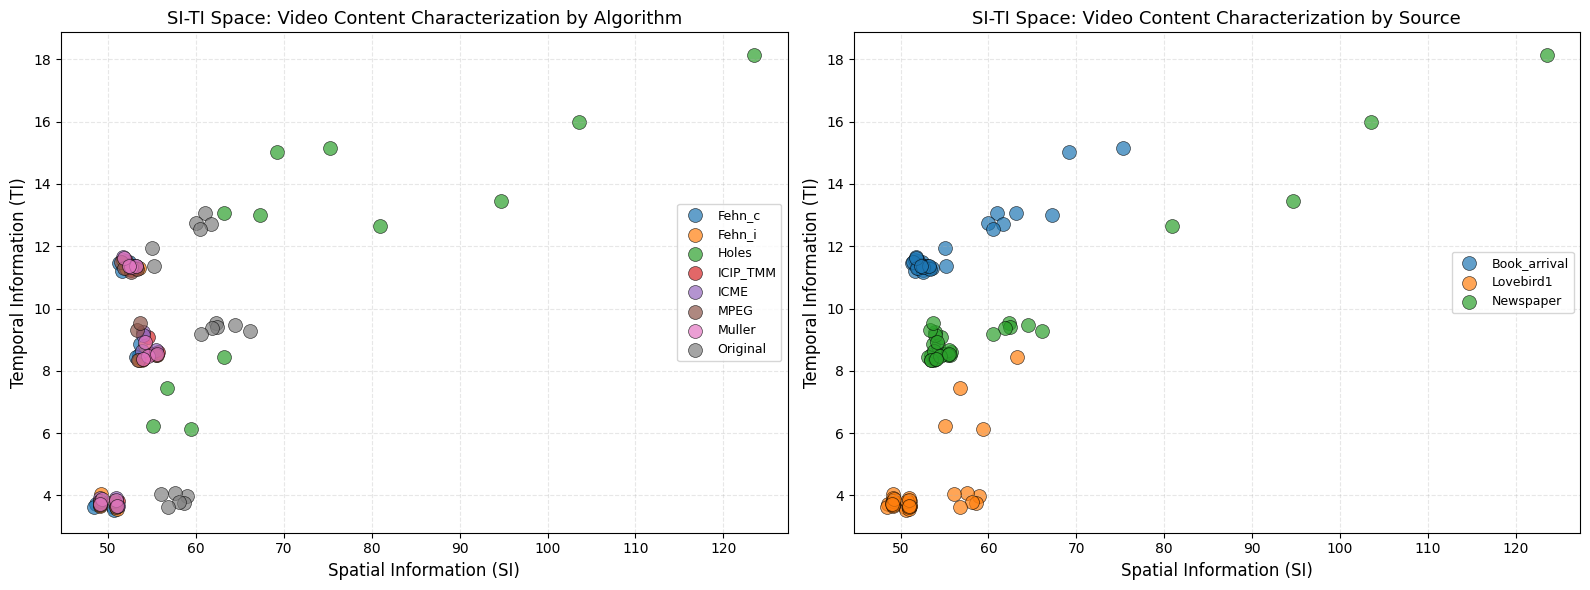

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df_videos['Algo'].unique()):
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(loc='right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

for source in sorted(df_videos['Video_ID'].unique()):
    subset = df_videos[df_videos['Video_ID'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(loc='right', fontsize=9)

plt.tight_layout()
plt.show()

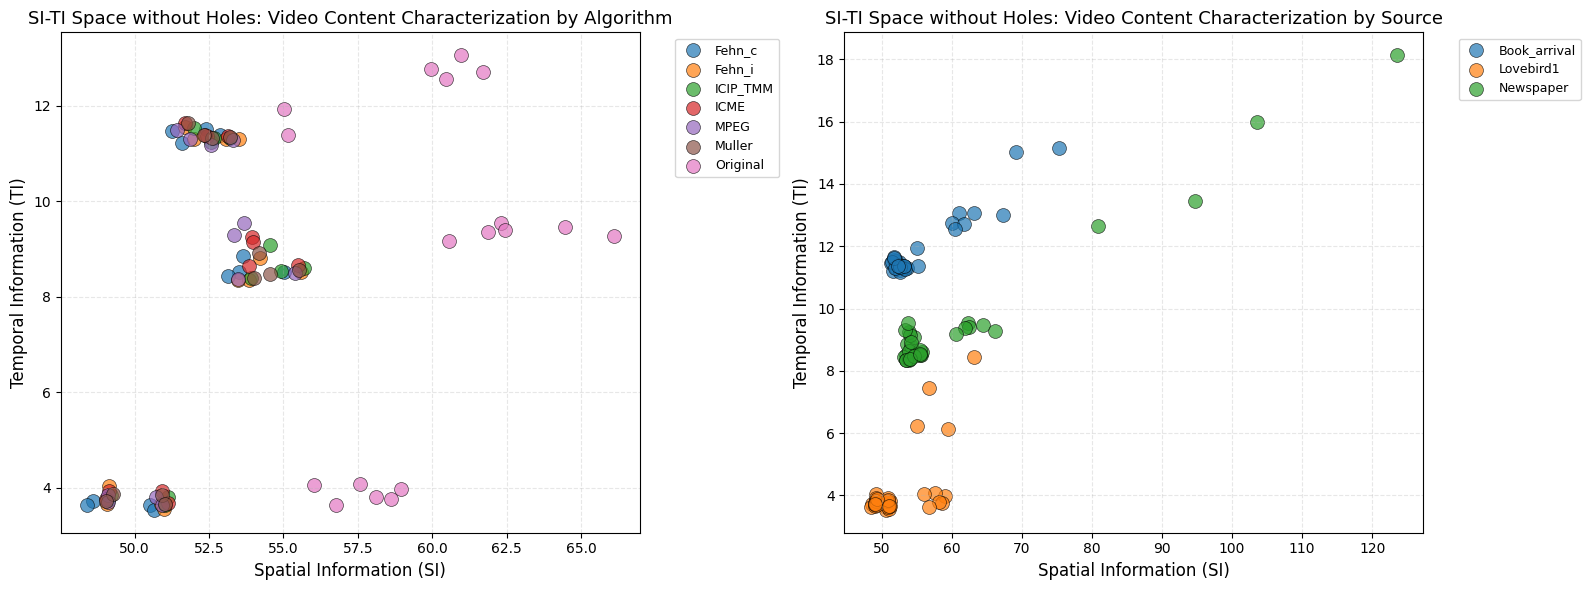

In [29]:
# Same graph but without Holes because it skews the scale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for algo in sorted(df_videos['Algo'].unique()):
    if algo == "Holes":
        continue
    subset = df_videos[df_videos['Algo'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space without Holes: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')
for source in sorted(df_videos['Video_ID'].unique()):
    subset = df_videos[df_videos['Video_ID'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space without Holes: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [30]:
# Filter out NaN values for analysis (only non-Original videos have objective metrics)
df_metrics = df_videos[df_videos['Algo'] != 'Original'].copy()
df_metrics = df_metrics.dropna(subset=['PSNR', 'LPIPS_alex', 'VIF', 'MOS'])

print(f"\n" + "="*70)
print("METRICS STATISTICS")
print("="*70)
print(df_metrics[['PSNR', 'LPIPS_alex', 'VIF', 'MOS']].describe())


METRICS STATISTICS
            PSNR  LPIPS_alex        VIF        MOS
count  84.000000   84.000000  84.000000  84.000000
mean   23.764506    0.137583   0.906424   2.094494
std     4.143481    0.076264   0.047856   0.571176
min    13.903742    0.073192   0.731084   1.125000
25%    21.774975    0.094143   0.898159   1.835938
50%    24.055146    0.107293   0.923656   2.000000
75%    24.871950    0.136769   0.932973   2.343750
max    32.899576    0.390552   0.952567   3.750000


### Pearson, Spearman and correlation matrix

In [31]:
#imported from coeff_func.py from tp2

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.optimize import fmin
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.optimize import leastsq
def logistic(t, x):
    return 0.5 - (1 / (1 + np.exp(t * x)))

def fitfun(t, x):
    res = t[0] * (logistic(t[1], (x-t[2]))) + t[3] + t[4] * x
    return res

def errfun(t, x, y):
    return np.sum(np.power(y - fitfun(t, x),2))

def RMSE(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse  

def coeff_fit(Obj,y) :
    temp = pearsonr(Obj, y)
    t = np.zeros(5)
    t[2] = np.mean(Obj)
    t[3] = np.mean(y)
    t[1] = 1/np.std(Obj)
    t[0] = abs(np.max(y) - np.min(y))    
    t[4] = -1
    signslope = 1
    if temp[1]<=0:
        t[0] *= -1
        signslope *= -1     
    v = [t, Obj, y]
    tt = fmin(errfun, t, args=(Obj, y))
    fit = fitfun(tt, Obj)
    cc = pearsonr(fit, y)[0]
    srocc = spearmanr(fit, y).correlation
    krocc = kendalltau(fit, y).correlation
    rmse = RMSE( np.absolute(y), np.absolute(fit) )
    return  fit, cc, srocc, krocc, rmse
 

In [32]:
results = {}
for metric in ['PSNR', 'LPIPS_alex', 'VIF']:
    valid_data = df_metrics[[metric, 'MOS']].dropna()
    
    fit_mos, cc, srocc, krocc, rmse = coeff_fit(
        valid_data[metric].values, 
        valid_data['MOS'].values
    )
    
    results[metric] = {
        'pearson_fitted': cc,
        'spearman_fitted': srocc,
        'kendall_fitted': krocc,
        'rmse': rmse
    }
    
    print(f"{metric}:")
    print(f"  Fitted Pearson:  {cc:.4f}")
    print(f"  Fitted Spearman: {srocc:.4f}")
    print(f"  RMSE: {rmse:.4f}")

Optimization terminated successfully.
         Current function value: 23.033622
         Iterations: 572
         Function evaluations: 938
PSNR:
  Fitted Pearson:  0.3868
  Fitted Spearman: 0.4519
  RMSE: 0.5237
LPIPS_alex:
  Fitted Pearson:  0.4790
  Fitted Spearman: 0.4965
  RMSE: 0.4984
Optimization terminated successfully.
         Current function value: 26.317083
         Iterations: 171
         Function evaluations: 301
VIF:
  Fitted Pearson:  0.1676
  Fitted Spearman: -0.2618
  RMSE: 0.5597


C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\96858281.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  tt = fmin(errfun, t, args=(Obj, y))


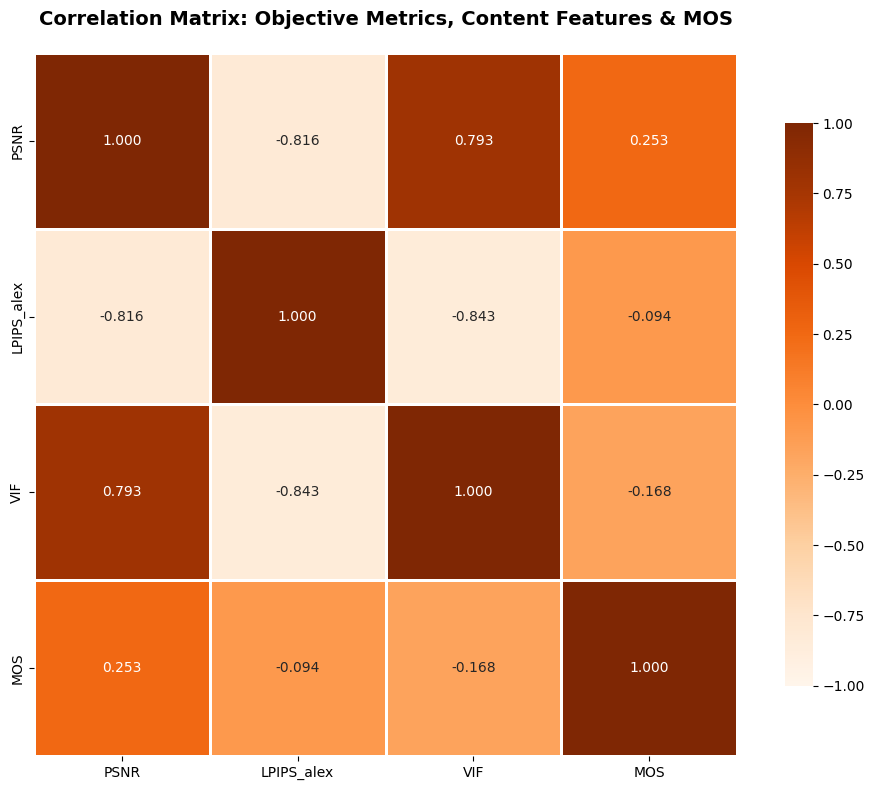


Correlation Matrix with MOS (Subjective Quality):
----------------------------------------------------------------------
MOS           1.000000
PSNR          0.253285
LPIPS_alex   -0.093695
VIF          -0.167642
Name: MOS, dtype: float64


In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

metrics_list = ['PSNR', 'LPIPS_alex', 'VIF', 'MOS']
corr_matrix = df_metrics[metrics_list].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='Oranges', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix: Objective Metrics, Content Features & MOS', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix with MOS (Subjective Quality):")
print("-" * 70)
print(corr_matrix['MOS'].sort_values(ascending=False))

#### Debug corelation


1. PLAGE DE VALEURS:
   MOS: [1.125, 3.750]
   PSNR: [13.904, 32.900]
   LPIPS: [0.073, 0.391]
   VIF: [0.731, 0.953]

2. VARIANCE DES MÉTRIQUES:
   MOS variance: 0.326
   PSNR variance: 17.168
   LPIPS variance: 0.006
   VIF variance: 0.002


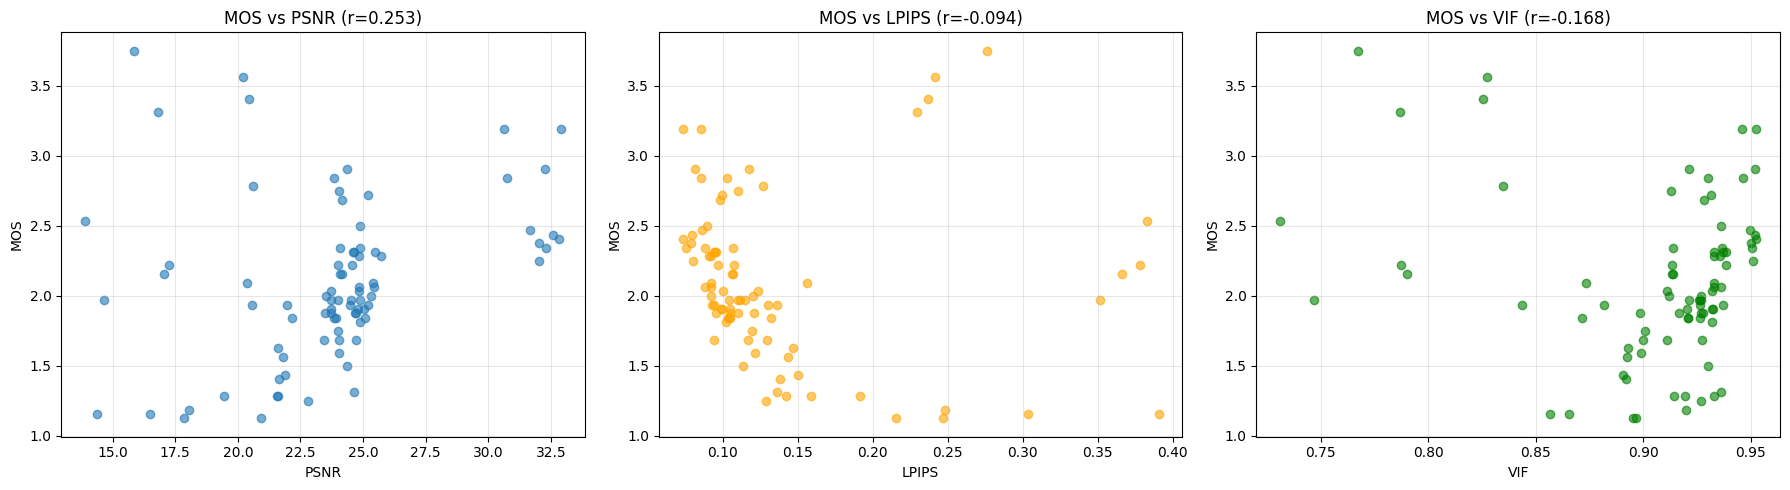


3. MOS PAR ALGORITHME:
   Fehn_c          → MOS: 2.698 ± 0.686
   Fehn_i          → MOS: 2.411 ± 0.466
   Holes           → MOS: 1.279 ± 0.166
   ICIP_TMM        → MOS: 2.130 ± 0.450
   ICME            → MOS: 1.964 ± 0.285
   MPEG            → MOS: 2.141 ± 0.374
   Muller          → MOS: 2.039 ± 0.253

4. MOS PAR VIDEO SOURCE:
   Book_arrival    → MOS: 2.206 ± 0.645
   Lovebird1       → MOS: 2.048 ± 0.405
   Newspaper       → MOS: 2.029 ± 0.635


In [34]:

print("\n1. PLAGE DE VALEURS:")
print(f"   MOS: [{df_metrics['MOS'].min():.3f}, {df_metrics['MOS'].max():.3f}]")
print(f"   PSNR: [{df_metrics['PSNR'].min():.3f}, {df_metrics['PSNR'].max():.3f}]")
print(f"   LPIPS: [{df_metrics['LPIPS_alex'].min():.3f}, {df_metrics['LPIPS_alex'].max():.3f}]")
print(f"   VIF: [{df_metrics['VIF'].min():.3f}, {df_metrics['VIF'].max():.3f}]")


print("\n2. VARIANCE DES MÉTRIQUES:")
print(f"   MOS variance: {df_metrics['MOS'].var():.3f}")
print(f"   PSNR variance: {df_metrics['PSNR'].var():.3f}")
print(f"   LPIPS variance: {df_metrics['LPIPS_alex'].var():.3f}")
print(f"   VIF variance: {df_metrics['VIF'].var():.3f}")


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MOS vs PSNR
axes[0].scatter(df_metrics['PSNR'], df_metrics['MOS'], alpha=0.6)
axes[0].set_xlabel('PSNR')
axes[0].set_ylabel('MOS')
axes[0].set_title(f'MOS vs PSNR (r={df_metrics[["PSNR", "MOS"]].corr().iloc[0,1]:.3f})')
axes[0].grid(alpha=0.3)

# MOS vs LPIPS
axes[1].scatter(df_metrics['LPIPS_alex'], df_metrics['MOS'], alpha=0.6, color='orange')
axes[1].set_xlabel('LPIPS')
axes[1].set_ylabel('MOS')
axes[1].set_title(f'MOS vs LPIPS (r={df_metrics[["LPIPS_alex", "MOS"]].corr().iloc[0,1]:.3f})')
axes[1].grid(alpha=0.3)

# MOS vs VIF
axes[2].scatter(df_metrics['VIF'], df_metrics['MOS'], alpha=0.6, color='green')
axes[2].set_xlabel('VIF')
axes[2].set_ylabel('MOS')
axes[2].set_title(f'MOS vs VIF (r={df_metrics[["VIF", "MOS"]].corr().iloc[0,1]:.3f})')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n3. MOS PAR ALGORITHME:")
for algo in sorted(df_metrics['Algo'].unique()):
    subset = df_metrics[df_metrics['Algo'] == algo]
    print(f"   {algo:15} → MOS: {subset['MOS'].mean():.3f} ± {subset['MOS'].std():.3f}")
    
print("\n4. MOS PAR VIDEO SOURCE:")
for video_id in sorted(df_metrics['Video_ID'].unique()):
    subset = df_metrics[df_metrics['Video_ID'] == video_id]
    print(f"   {video_id:15} → MOS: {subset['MOS'].mean():.3f} ± {subset['MOS'].std():.3f}")

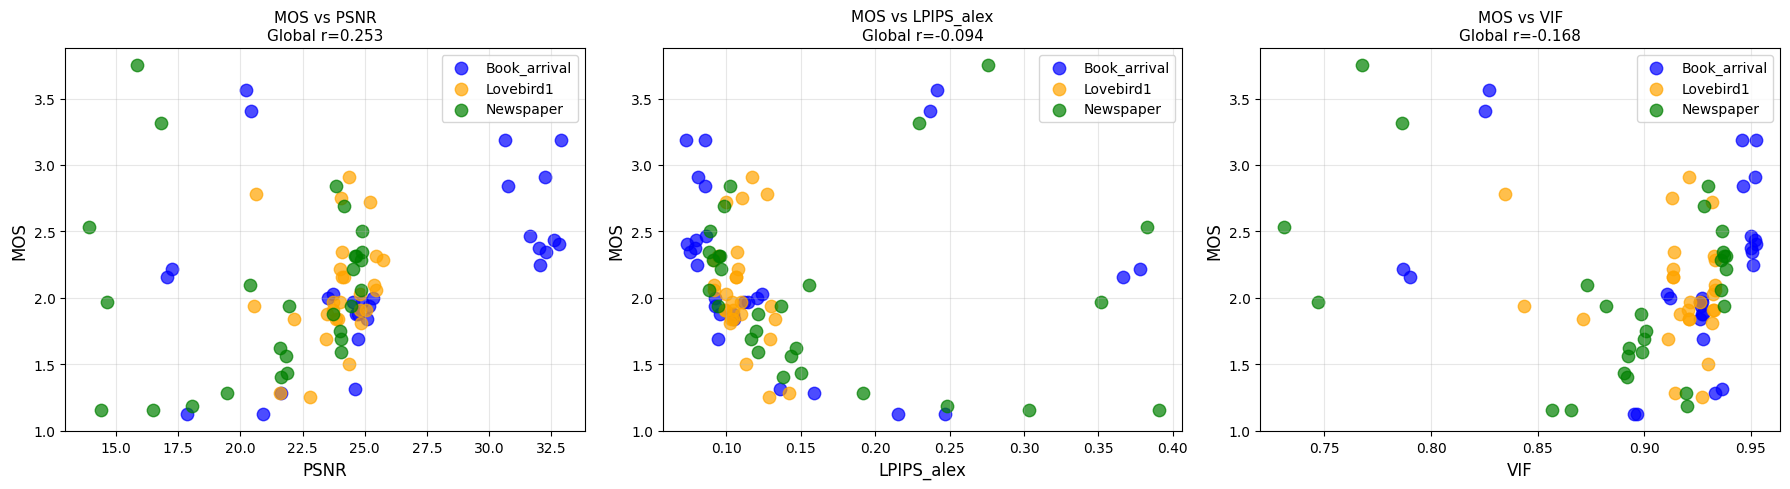


Book_arrival:
  PSNR         vs MOS: r = +0.3824
  LPIPS_alex   vs MOS: r = -0.0800
  VIF          vs MOS: r = -0.1119

Lovebird1:
  PSNR         vs MOS: r = +0.1963
  LPIPS_alex   vs MOS: r = -0.3063
  VIF          vs MOS: r = -0.1749

Newspaper:
  PSNR         vs MOS: r = +0.0251
  LPIPS_alex   vs MOS: r = -0.0975
  VIF          vs MOS: r = -0.2813

Overall correlations:
  PSNR         vs MOS: r = +0.2533
  LPIPS_alex   vs MOS: r = -0.0937
  VIF          vs MOS: r = -0.1676


In [35]:
###### Side note : for the presentation we forgot to mention that we saw
###### the content is absolutely not related to the 'noise' that we tried to understand
###### and we thought that it wasn't relevant to show that the source doesn't not answer to our question


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Couleurs par source
colors = {'Book_arrival': 'blue', 'Lovebird1': 'orange', 'Newspaper': 'green'}

for idx, metric in enumerate(['PSNR', 'LPIPS_alex', 'VIF']):
    ax = axes[idx]
    
    for video_id in sorted(df_metrics['Video_ID'].unique()):
        subset = df_metrics[df_metrics['Video_ID'] == video_id]
        ax.scatter(subset[metric], subset['MOS'], 
                  label=video_id, alpha=0.7, 
                  color=colors[video_id], s=80)
    
    global_corr = df_metrics[[metric, 'MOS']].corr().iloc[0,1]
    
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('MOS', fontsize=12)
    ax.set_title(f'MOS vs {metric}\nGlobal r={global_corr:.3f}', fontsize=11)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

for video_id in sorted(df_metrics['Video_ID'].unique()):
    subset = df_metrics[df_metrics['Video_ID'] == video_id]
    print(f"\n{video_id}:")
    
    for metric in ['PSNR', 'LPIPS_alex', 'VIF']:
        corr = subset[[metric, 'MOS']].corr().iloc[0,1]
        print(f"  {metric:12} vs MOS: r = {corr:+.4f}")

print("\nOverall correlations:")
for metric in ['PSNR', 'LPIPS_alex', 'VIF']:
    corr = df_metrics[[metric, 'MOS']].corr().iloc[0,1]
    print(f"  {metric:12} vs MOS: r = {corr:+.4f}")

#### Impact of video type and algorithm on metrics 

CONTENT IMPACT

Book_arrival:
  Samples: 28
  MOS: 2.206 ± 0.645
  PSNR: 25.937 ± 5.166 dB
  LPIPS: 0.137 ± 0.085
  VIF: 0.915 ± 0.048

Lovebird1:
  Samples: 28
  MOS: 2.048 ± 0.405
  PSNR: 23.915 ± 1.342 dB
  LPIPS: 0.109 ± 0.013
  VIF: 0.916 ± 0.025

Newspaper:
  Samples: 28
  MOS: 2.029 ± 0.635
  PSNR: 21.441 ± 3.711 dB
  LPIPS: 0.166 ± 0.094
  VIF: 0.888 ± 0.060


C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\1552362763.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_type, labels=video_ids, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\1552362763.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_type, labels=video_ids, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\1552362763.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_type, labels=video_ids, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\1552362763.py:23: MatplotlibDepr

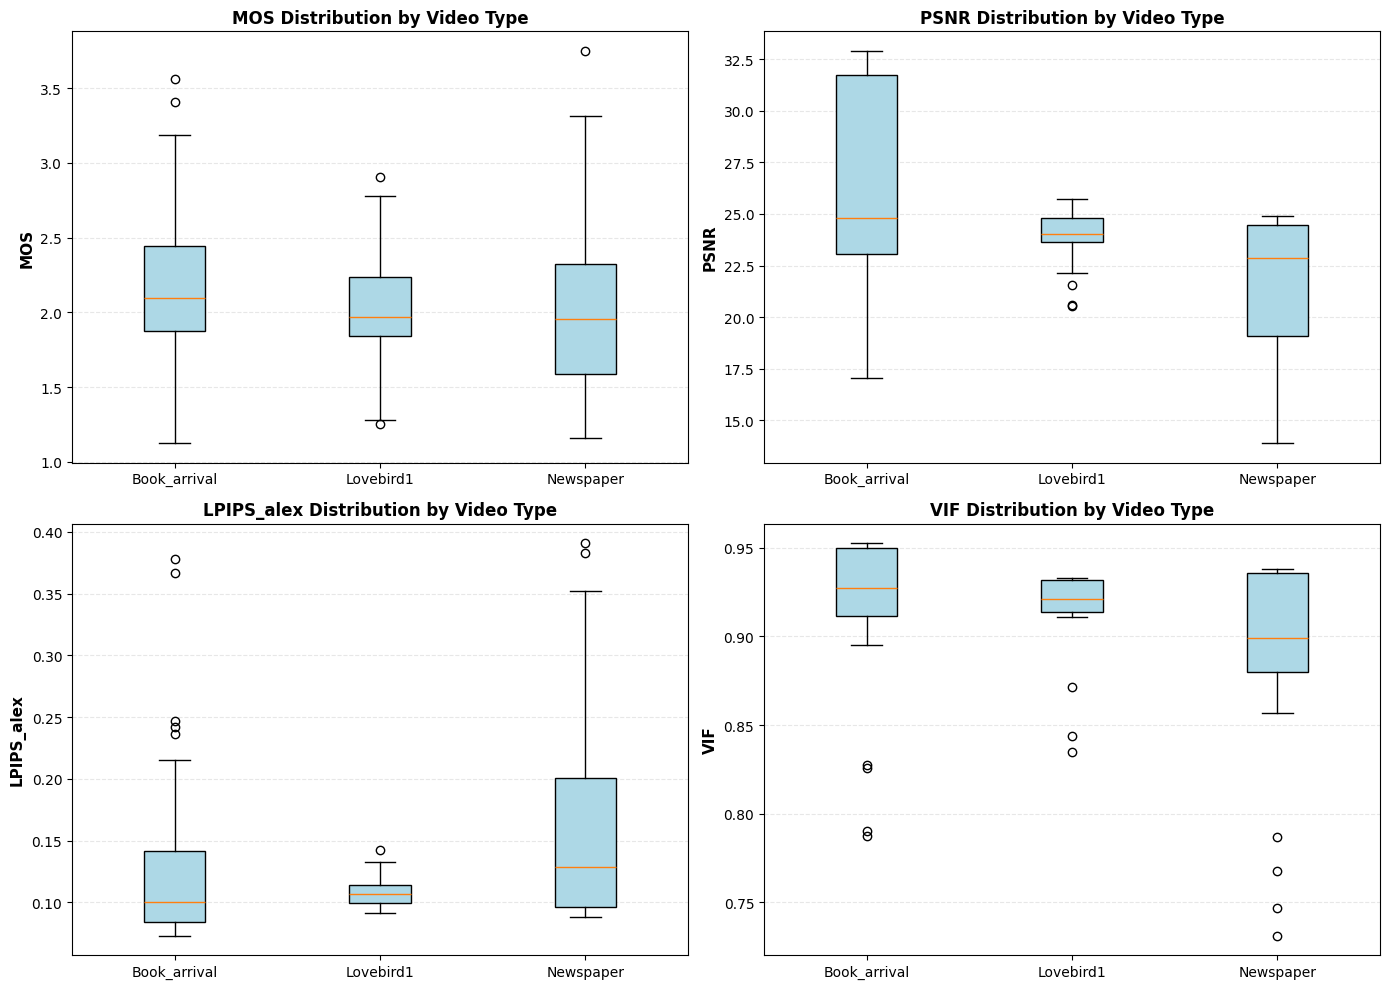

In [36]:
### 6. Content Impact Analysis: Metrics by Video Type
print("CONTENT IMPACT")

for video_id in sorted(df_metrics['Video_ID'].unique()):
    subset = df_metrics[df_metrics['Video_ID'] == video_id]
    print(f"\n{video_id}:")
    print(f"  Samples: {len(subset)}")
    print(f"  MOS: {subset['MOS'].mean():.3f} ± {subset['MOS'].std():.3f}")
    print(f"  PSNR: {subset['PSNR'].mean():.3f} ± {subset['PSNR'].std():.3f} dB")
    print(f"  LPIPS: {subset['LPIPS_alex'].mean():.3f} ± {subset['LPIPS_alex'].std():.3f}")
    print(f"  VIF: {subset['VIF'].mean():.3f} ± {subset['VIF'].std():.3f}")

# Visualization: Metrics by video type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['MOS', 'PSNR', 'LPIPS_alex', 'VIF']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    video_ids = sorted(df_metrics['Video_ID'].unique())
    data_by_type = [df_metrics[df_metrics['Video_ID'] == vid][metric].values for vid in video_ids]
    
    bp = ax.boxplot(data_by_type, labels=video_ids, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Distribution by Video Type', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

CONTENT IMPACT:by ALGORITHM

Metric means and std by Algorithm:
             MOS             PSNR         LPIPS_alex             VIF        
            mean     std     mean     std       mean     std    mean     std
Algo                                                                        
Fehn_c    2.6979  0.6859  18.6538  3.1980     0.2474  0.1045  0.8110  0.0538
Fehn_i    2.4115  0.4656  24.6209  3.0806     0.1116  0.0203  0.9180  0.0223
Holes     1.2786  0.1661  20.4638  3.2485     0.2003  0.0846  0.9088  0.0258
ICIP_TMM  2.1302  0.4501  25.7574  3.2762     0.0999  0.0201  0.9266  0.0185
ICME      1.9635  0.2854  25.6660  3.3617     0.0980  0.0175  0.9267  0.0182
MPEG      2.1406  0.3744  25.5641  3.1247     0.1041  0.0172  0.9267  0.0182
Muller    2.0391  0.2529  25.6254  3.2724     0.1018  0.0181  0.9271  0.0180


C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\451765323.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\451765323.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\451765323.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_31512\451765323.py:19: MatplotlibDeprecationWarning: 

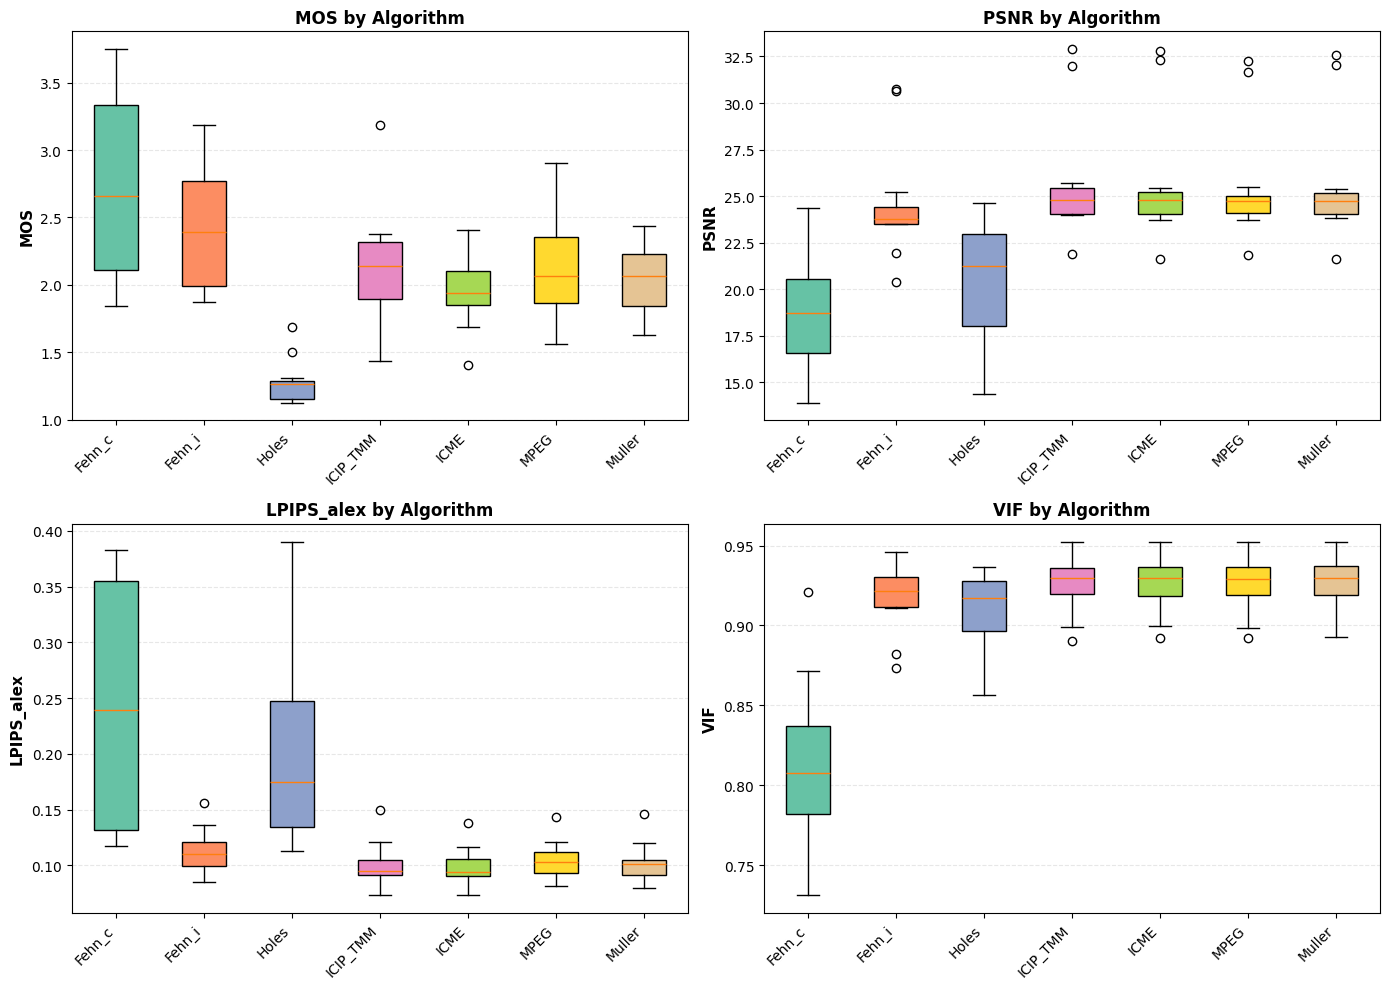


Interpretation:
- Algorithm ranking by MOS (subjective quality)
  Fehn_c          → 2.698
  Fehn_i          → 2.411
  MPEG            → 2.141
  ICIP_TMM        → 2.130
  Muller          → 2.039
  ICME            → 1.964
  Holes           → 1.279


In [37]:
print("CONTENT IMPACT:by ALGORITHM")

algo_comparison = df_metrics.groupby('Algo')[['MOS', 'PSNR', 'LPIPS_alex', 'VIF']].agg(['mean', 'std'])
print("\nMetric means and std by Algorithm:")
print(algo_comparison.round(4))

# Visualization: Metrics by algorithm
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['MOS', 'PSNR', 'LPIPS_alex', 'VIF']
colors = sns.color_palette("Set2", len(df_metrics['Algo'].unique()))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    algos = sorted(df_metrics['Algo'].unique())
    data_by_algo = [df_metrics[df_metrics['Algo'] == algo][metric].values for algo in algos]
    
    bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} by Algorithm', fontsize=12, fontweight='bold')
    ax.set_xticklabels(algos, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Algorithm ranking by MOS (subjective quality)")
for algo in sorted(df_metrics.groupby('Algo')['MOS'].mean().sort_values(ascending=False).index, key=lambda x: df_metrics[df_metrics['Algo'] == x]['MOS'].mean(), reverse=True):
    mean_mos = df_metrics[df_metrics['Algo'] == algo]['MOS'].mean()
    print(f"  {algo:15} → {mean_mos:.3f}")
